# Overfitting a Transformer Autoencoder 

## Framing

> GOAL: Use a bunch of transformer encoder blocks to compress a small set of spacetime patches from a video into a small latent dimension bottleneck. Reconstruct the original patches from the latent dimension using some transformer decoder blocks. 

__Encoders__: The first 1-2 encoder blocks are unique. The remaining are the same (cf. Perceiver). 
 - {MHA -> FFN} + residual + layer norm. 
 - Question: How to get bottleneck on the first "cold start"? 
	 - Assumption: We start with the latent dimension initialized to zeros.
 - `latent -> latent`: Encoder only. 
 - `datum -> latent`: Query = latent; key/value = data. Residual connection with layernorm as before -> adds to the latent, doesn't overwrite. 

__Decoders__: We want to be able to map from `latent` -> `reconstruction`. 
 - We can query the latent state with the positional encodings of the desired patch positions!
 - Pretty much the same as the encoder 

## 0: Setup & Data Acquisition

In [1]:
## Import Box 
import os 
import sys 
import random
import pathlib
import itertools
import collections
import math

import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
from tqdm import tqdm
import cv2
# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

2022-10-05 15:20:44.821769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 15:20:45.146222: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-05 15:20:45.270421: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-05 15:20:46.181654: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
## Utility imports  
sys.path.append("../src")
import video_loader as vl
import video_preprocess as vp 

In [3]:
## Meta/constants 
DATA_FOLDER = "../datasets/downloads"
num_videos, num_frames = 16, 11
output_size = (240, 360)

patch_height = 16
patch_width = 16
patch_duration = 3

batch_size=1

# Fourier feature codes 
k_space = 15
mu_space = 20 
k_time = 64 
mu_time = 200

In [5]:
print("Getting VideoSet...")
VideoSet = vl.get_videoset("../datasets/downloads", num_videos, num_frames, output_size=output_size)

print("Making patches from Videoset...")
PatchSet = vp.make_patchset(VideoSet, patch_duration, patch_height, patch_width)

print("Making the flat patch set...")
FlatPatchSet = vp.patch_to_flatpatch(PatchSet, batch_size=batch_size)

print("Adding codes to the PatchSet...")
CodedPatchedSet = PatchSet.map(lambda x: vp.add_spacetime_codes(x, 
		k_space=k_space, mu_space=mu_space, k_time=k_time, mu_time=mu_time))

print("Flattening the coded + patched dataset...")
FlatCodedPatchedSet = vp.patch_to_flatpatch(CodedPatchedSet, batch_size=batch_size)

Getting VideoSet...


100%|██████████| 16/16 [00:01<00:00, 10.68it/s]


Making patches from Videoset...
Making the flat patch set...
Flattening a tensor of shape:  (None, 3, 15, 22, 2304)
Adding codes to the PatchSet...
Flattening the coded + patched dataset...
Flattening a tensor of shape:  (1, 3, 15, 22, 2495)


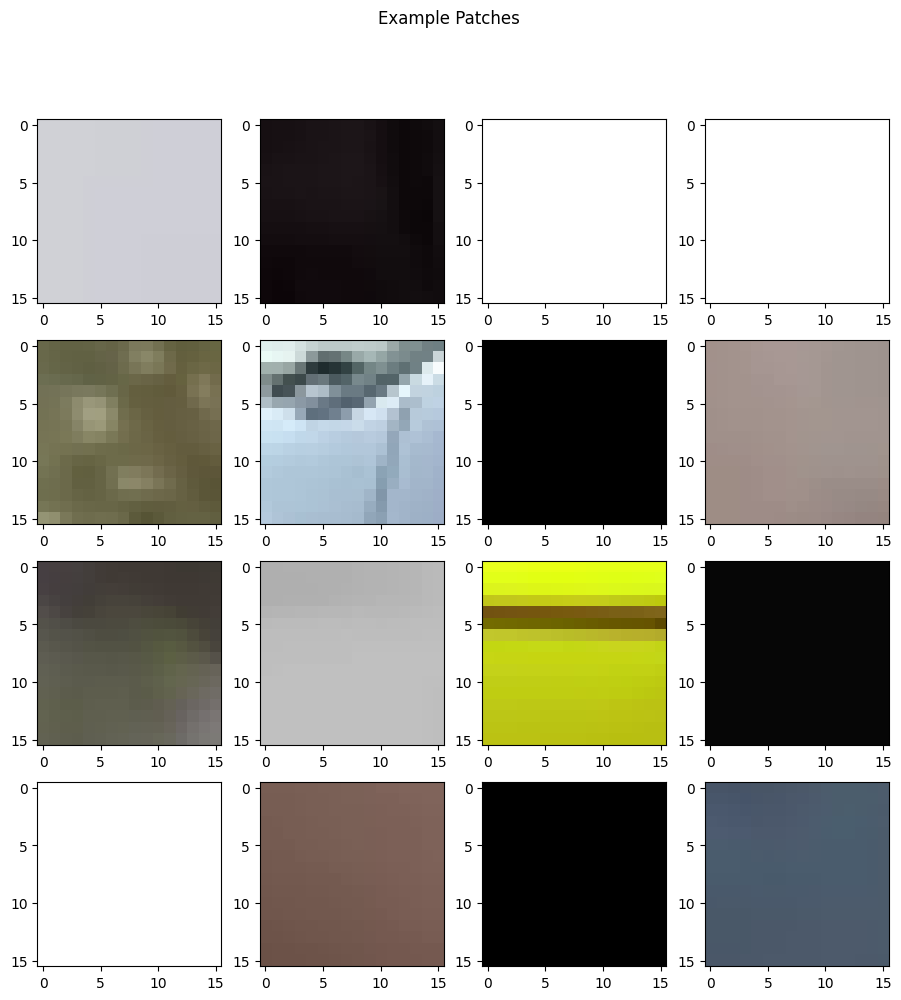

In [8]:
## Let's decode a single spacetime patch

nplots = math.ceil(math.sqrt(len(PatchSet)))
fig, axs = plt.subplots(nplots, nplots)
fig.set_figheight(11)
fig.set_figwidth(11)

cnt=0
for element in PatchSet: 
	# plt.imshow()tf.reshape(element[0,0,:,:,0]), (16,16,3)
	# print("Element shape: ", element.shape)
	first_patch = element[0,2,3,4,:]
	# print("First patch shape: ", first_patch.shape)
	first_patch = tf.reshape(first_patch, [patch_duration, patch_height, patch_width, 3] ) # time, height, width, channels 
	axs[cnt//nplots, cnt%nplots].imshow(first_patch[2,:,:,:])
	cnt+=1
plt.suptitle("Example Patches")
plt.show()

## 1: Super Simple TAE 

In [10]:
## Getting the patched + flattened + encoded tensor of shape [batch, tokens, token_dim]

flat_coded_1 = None 
for element in FlatCodedPatchedSet:
	flat_coded_1 = element 
	break

flat_coded_1.shape

TensorShape([1, 990, 2495])

In [12]:
## Some constants governing the basic model 

# ENCODER: data -> latent 
M = flat_coded_1.shape[1] # data token dimension 
D = flat_coded_1.shape[2] # data channel dimension

N = 124					  # latent token dimension 
C = 512 				  # latent channel dimension 

n_enc_heads = 16 
enc_key_dim = 48

ffn_inner_dim = 2048

In [27]:
def point_wise_feed_forward_network(
	d_model, # Input/output dimensionality.
	dff # Inner-layer dimensionality.
	):

	return tf.keras.Sequential([
		tf.keras.layers.Dense(dff, activation='relu'),  # Shape `(batch_size, seq_len, dff)`.
		tf.keras.layers.Dense(d_model)  # Shape `(batch_size, seq_len, d_model)`.
	])

In [28]:
## Functional model definition 
inputs = tf.keras.Input(shape=(M, D)) # for now, we keep these constant. 
								 	  # M can realistically change arbitrarily.

latent = tf.zeros([1, N, C]) # N rows (tokens), C channels (columns)

encoder_mha = tf.keras.layers.MultiHeadAttention(num_heads=n_enc_heads, key_dim=enc_key_dim)
encoder_ffn = point_wise_feed_forward_network(C, C*4)

inputs.shape

TensorShape([None, 990, 2495])

In [29]:
x1 = encoder_mha(latent, inputs)
x2 = encoder_ffn(x1)

In [30]:
x1.shape

TensorShape([1, 124, 512])

In [31]:
x2.shape

TensorShape([1, 124, 512])